In [1]:
import sys
sys.path.append('C:\\projects\\UTNCE\\src\\utnce202402')

In [2]:
from simplify import *
from prepare import *
from routing import *
from percolation_plot import *
from generate import *
from transfer import *
from copy import deepcopy
from shapely.geometry import Point,LineString
from pyproj import Proj, Transformer
import pickle
import itertools
import random
from sympy import symbols, Eq, solve

In [3]:
osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.large.pbf"

# Subway-Amsterdam 

## Generate Baseline network

In [4]:
# Obtain sub-stations in the city
city_sub_stations = sub_stations(osm_path)

In [5]:
# Obtain subway network data
city_sub_network = subway_network(osm_path)

# Prepare the network edges and nodes based on sub-stations and subway network
edges, nodes = prepare_network(city_sub_network, city_sub_stations)

# Expand the edges if required
edges = expand_edges(edges)

# Obtain sub-routes in the city
city_sub_routes = sub_routes(osm_path)

# Sort the sub-routes
city_sub_routes = sorted_routes(city_sub_routes)

# Check the name and assign a column
check_name = check_to_column(city_sub_routes, city_sub_stations)

topology: 100%|████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 8272.91it/s]


In [6]:
# gpd.GeoDataFrame(edges[['osm_id', 'geometry', 'id', 'from_id', 'to_id', 'distance', 'time', 'weights']]).to_file('edges_0408.GPKG',driver='GPKG')

In [7]:
id_nodes_length_sub = len(nodes)
id_edges_length_sub = len(edges)

In [8]:
id_edges_length_sub

962

In [9]:
city_sub_edges = pd.DataFrame(edges.copy())
city_sub_nodes = pd.DataFrame(nodes.copy())

In [10]:
# delete 3 pairs useless and wrong edges 
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 771) & (city_sub_edges['to_id'] == 761)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 771) & (city_sub_edges['to_id'] == 766)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 762) & (city_sub_edges['to_id'] == 771)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 767) & (city_sub_edges['to_id'] == 771)].index, inplace=True)

city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 780) & (city_sub_edges['to_id'] == 773)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 780) & (city_sub_edges['to_id'] == 772)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 774) & (city_sub_edges['to_id'] == 780)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 775) & (city_sub_edges['to_id'] == 780)].index, inplace=True)

city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 180) & (city_sub_edges['to_id'] == 345)].index, inplace=True)

city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 491) & (city_sub_edges['to_id'] == 492)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 498) & (city_sub_edges['to_id'] == 499)].index, inplace=True)



city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 634) & (city_sub_edges['to_id'] == 635)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 654) & (city_sub_edges['to_id'] == 655)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 584) & (city_sub_edges['to_id'] == 585)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 569) & (city_sub_edges['to_id'] == 570)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 588) & (city_sub_edges['to_id'] == 589)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 577) & (city_sub_edges['to_id'] == 589)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 607) & (city_sub_edges['to_id'] == 577)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 564) & (city_sub_edges['to_id'] == 565)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 586) & (city_sub_edges['to_id'] == 587)].index, inplace=True)

city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 643) & (city_sub_edges['to_id'] == 644)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 638) & (city_sub_edges['to_id'] == 639)].index, inplace=True)

city_sub_edges = city_sub_edges.reset_index(drop = True)

In [11]:
# revise Zuid metro stations' coordinates, replace 712 with 180 and 345 nodes to avoid wrong shortest-path edges
geometry_value1 = city_sub_nodes.loc[city_sub_nodes['id'] == 180, 'geometry'].values[0]
geometry_value2 = city_sub_nodes.loc[city_sub_nodes['id'] == 345, 'geometry'].values[0]

city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737797', 'geometry'] = geometry_value1
city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737797', 'geo_x'] = geometry_value1.x
city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737797', 'geo_y'] = geometry_value1.y

city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737796', 'geometry'] = geometry_value2
city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737796', 'geo_x'] = geometry_value2.x
city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737796', 'geo_y'] = geometry_value2.y

In [12]:
replacement_dict = {
     'Amsterdam Centraal': 'Centraal Station',
}

In [13]:
# Replace values in the 'to' column of the metro routes using the replacement dictionary
city_sub_routes['to'] = city_sub_routes['to'].replace(replacement_dict, regex=True).str.strip()

# Reset the index of the metro routes
city_sub_routes = city_sub_routes.reset_index(drop=True)

# Check if the values in the 'to' column of the metro routes match the station names
check_name = check_to_column(city_sub_routes, city_sub_stations)

In [14]:
# gpd.GeoDataFrame(city_sub_edges[['osm_id', 'geometry', 'id', 'from_id', 'to_id', 'distance', 'time', 'weights']]).to_file('city_sub_edges_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(city_sub_stations[['osm_id', 'geometry','name']]).to_file('city_sub_stations_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(city_sub_nodes[['geometry','degree','id']]).to_file('city_sub_nodes_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(city_sub_routes[['osm_id', 'route', 'name', 'geometry']]).to_file('city_sub_routes_0417.GPKG',driver='GPKG')

In [15]:
# # 将DataFrame保存为pickle文件
# city_sub_edges.to_pickle('city_sub_edges_0328.pkl')
# city_sub_stations.to_pickle('city_sub_stations_0328.pkl')
# city_sub_nodes.to_pickle('city_sub_nodes_0328.pkl')
# city_sub_routes.to_pickle('city_sub_routes_0328.pkl')

In [16]:
# Create a dictionary mapping start stations to their corresponding routes
city_sub_start_station_name_dict = start_station_dict(city_sub_routes)

# Create a dictionary mapping subway lines to their corresponding routes
city_sub_line_dict = line_dict(city_sub_routes)

# Create a list of all station names in the city's subway network
city_all_sub_stations_name = all_station_list(city_sub_stations)

# Create a dictionary mapping subway lines to the ordered list of stations on each line
city_sub_order_route_dict = order_stations_inline(city_sub_line_dict, city_all_sub_stations_name, city_sub_routes, city_sub_start_station_name_dict)

In [17]:
# revise station sequence of 51_1 route
df51_1 = pd.read_excel('C:\\projects\\UTNCE\\data\\Metro 51 Centraal Station = Isolatorweg.xlsx',header=None)
df51_1 = df51_1[0::4].reset_index(drop=True)
df51_1.columns = ['name']
df51_1.name[9] = 'Zuid' 
df51_1.name[13] = 'Lelylaan' 
df51_1.name[16] = 'De Vlugtlaan' 

df = city_sub_order_route_dict['Metro 51: Centraal Station => Isolatorweg']
df_reordered = pd.merge(df51_1,df,on='name')

desired_order = ['id', 'name', 'geometry', 'geo_x', 'geo_y']
df_reordered = df_reordered[desired_order]

key_to_replace = 'Metro 51: Centraal Station => Isolatorweg'
city_sub_order_route_dict[key_to_replace] = df_reordered

# city_sub_order_route_dict

In [18]:
df52_metro_1 = city_sub_order_route_dict['Metro 52: Noord => Zuid']
df52_metro_2 = city_sub_order_route_dict['Metro 52: Zuid => Noord']

df52_metro_1_dep = df52_metro_1[df52_metro_1.name == 'De Pijp'].copy()
df52_metro_2_dep = df52_metro_2[df52_metro_2.name == 'De Pijp'].copy()


columns_to_swap = ['geometry', 'geo_x', 'geo_y']
for column in columns_to_swap:
    temp = df52_metro_1_dep[column].copy()
    df52_metro_1_dep.loc[df52_metro_1_dep['name'] == 'De Pijp', column] = df52_metro_2_dep.loc[df52_metro_2_dep['name'] == 'De Pijp', column].values
    df52_metro_2_dep.loc[df52_metro_2_dep['name'] == 'De Pijp', column] = temp.values

df52_metro_1.loc[df52_metro_1['name'] == 'De Pijp', columns_to_swap] = df52_metro_1_dep[columns_to_swap].values
df52_metro_2.loc[df52_metro_2['name'] == 'De Pijp', columns_to_swap] = df52_metro_2_dep[columns_to_swap].values

# city_sub_order_route_dict

In [19]:
# Create a dictionary mapping subway lines to the pairs of station IDs on each line
city_sub_order_id_pairs = id_pairs_inline(city_sub_line_dict, city_sub_order_route_dict, city_sub_nodes)

In [20]:
# Create a graph representing the subway network using the extracted edges and nodes
G = create_ground_graph(city_sub_edges, city_sub_nodes)

# Calculate the shortest path id pairs for each subway line

city_sub_all_shortest_paths_id_dict = city_sub_order_id_pairs.copy()


for line in city_sub_order_id_pairs.keys():
    # Calculate all shortest paths id for the current line using the subway network edges
    city_sub_all_shortest_paths_id_dict[line] = all_shortest_path_id_list(G, city_sub_order_id_pairs[line], city_sub_edges)

In [21]:
# city_sub_all_shortest_paths_id_dict

In [22]:
city_sub_ordered_edges = edges_revise_direction(city_sub_all_shortest_paths_id_dict,city_sub_edges)
city_sub_ordered_edges

,from_id,to_id,osm_id,geometry,railway,service,id,distance,time,weights,from_to,to_from
0,1,0,23157994,"LINESTRING (4.9236699 52.3361909, 4.9236979 52...",subway,None,0,258.660599,0.010346,258,"(1, 0)","(0, 1)"
1,2,3,23158053,"LINESTRING (4.9642294 52.2945339, 4.9644259 52...",subway,None,1,215.433271,0.008617,215,"(2, 3)","(3, 2)"
2,4,5,23158054,"LINESTRING (4.9622901 52.2955678, 4.9624673 52...",subway,None,2,121.794737,0.004872,121,"(4, 5)","(5, 4)"
3,7,6,23189033,"LINESTRING (4.8467318 52.3952137, 4.8471439 52...",subway,None,3,28.046592,0.001122,28,"(7, 6)","(6, 7)"
4,492,8,23189039,"LINESTRING (4.8409161 52.3937679, 4.8416087 52...",subway,None,4,382.935219,0.015317,382,"(492, 8)","(8, 492)"
...,...,...,...,...,...,...,...,...,...,...,...,...
935,803,463,1131538381,"LINESTRING (4.9200955 52.3417374, 4.9200444 52...",subway,None,957,73.656989,0.002946,73,"(803, 463)","(463, 803)"
936,462,803,1131538382,"LINESTRING (4.9201445 52.3416568, 4.9200955 52...",subway,None,958,9.568427,0.000383,9,"(462, 803)","(803, 462)"
937,246,804,1131538383,"LINESTRING (4.9200365 52.3417239, 4.9200773 52...",subway,None,959,9.568874,0.000383,9,"(246, 804)","(804, 246)"
938,804,463,1131538384,"LINESTRING (4.9197172 52.3423576, 4.9197589 52...",subway,None,960,73.789113,0.002952,73,"(804, 463)","(463, 804)"


In [23]:
G = nx.DiGraph()

for _, row in city_sub_nodes.iterrows():
    node = row['id']  # Assuming 'id' is the node identifier
    geometry = row['geometry']
    x, y = geometry.x, geometry.y
    G.add_node(node, pos=(x, y))
    
# Extract the edges from the input DataFrame and create a list of tuples with time
od = city_sub_ordered_edges[['from_id', 'to_id', 'time', 'weights']]
edges_list = []
for i, row in od.iterrows():
    weight_dict = {"weight": row[2]*60}
    tuple_row = (row[0], row[1], weight_dict)
    edges_list.append(tuple_row)
# edges_list
G.add_edges_from(edges_list)

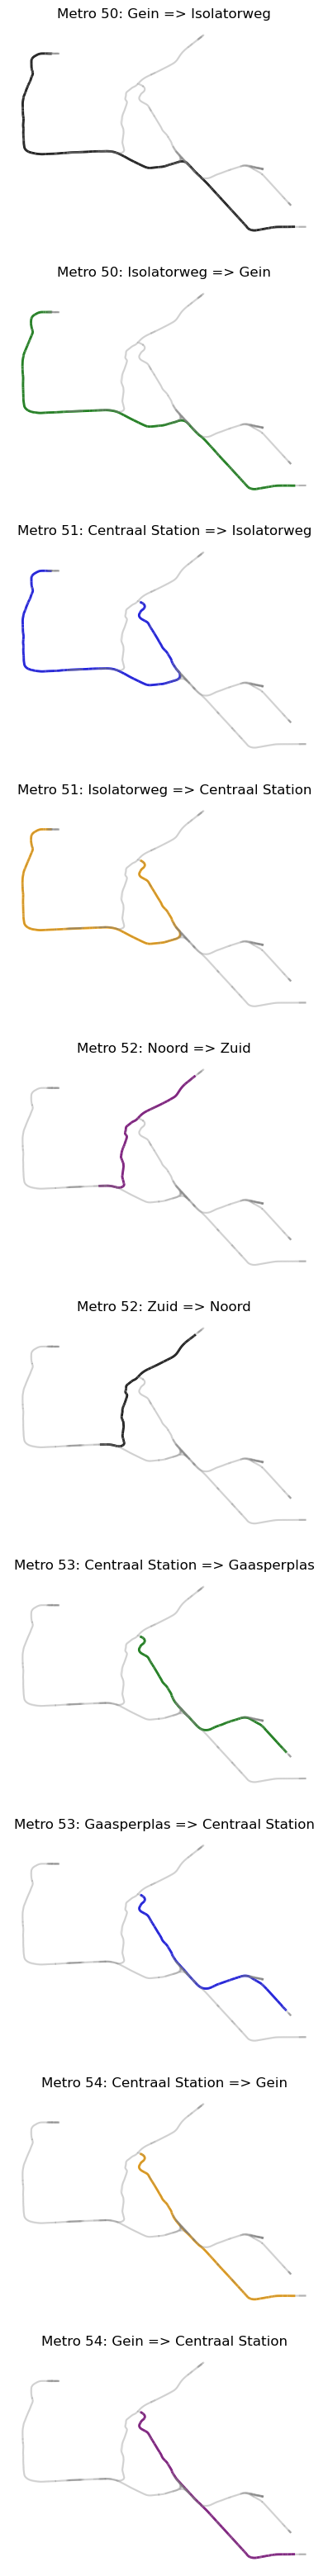

In [24]:
# Calculate the shortest path pairs for each subway line
city_sub_shortest_path_pairs_dict = city_sub_order_id_pairs.copy()
duplicate_row_count = city_sub_order_id_pairs.copy()
city_sub_shortest_path_edges_dict = city_sub_order_id_pairs.copy()
city_sub_edges_dict = city_sub_order_id_pairs.copy()

for line in city_sub_order_id_pairs.keys():
    # Calculate all shortest paths for the current line using the subway network edges
    city_sub_shortest_path_pairs_dict[line] = all_shortest_paths(G, city_sub_order_id_pairs[line], city_sub_ordered_edges)

    # Count the duplicate rows, calculate the weighted edges for shortest paths,
    # and update the subway network edges for the current line
    duplicate_row_count[line], city_sub_shortest_path_edges_dict[line], city_sub_edges_dict[line] = edges_with_count_weight(city_sub_shortest_path_pairs_dict[line], city_sub_ordered_edges)
    
# Plot all subway routes
plot_routes(city_sub_routes, city_sub_ordered_edges, city_sub_shortest_path_edges_dict)

In [25]:
# df50_1 = city_sub_shortest_path_edges_dict['Metro 50: Gein => Isolatorweg']
# df50_2 = city_sub_shortest_path_edges_dict['Metro 50: Isolatorweg => Gein']

# df51_1 = city_sub_shortest_path_edges_dict['Metro 51: Centraal Station => Isolatorweg']
# df51_2 = city_sub_shortest_path_edges_dict['Metro 51: Isolatorweg => Centraal Station']

# df52_1 = city_sub_shortest_path_edges_dict['Metro 52: Noord => Zuid'] 
# df52_2 = city_sub_shortest_path_edges_dict['Metro 52: Zuid => Noord']

# df53_1 = city_sub_shortest_path_edges_dict['Metro 53: Centraal Station => Gaasperplas']
# df53_2 = city_sub_shortest_path_edges_dict['Metro 53: Gaasperplas => Centraal Station']

# df54_1 = city_sub_shortest_path_edges_dict['Metro 54: Centraal Station => Gein']
# df54_2 = city_sub_shortest_path_edges_dict['Metro 54: Gein => Centraal Station']

In [26]:
# gpd.GeoDataFrame(df50_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df50_1_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df50_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df50_2_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df51_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df51_1_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df51_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df51_2_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df52_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df52_1_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df52_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df52_2_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df53_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df53_1_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df53_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df53_2_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df54_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df54_1_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df54_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df54_2_0417.GPKG',driver='GPKG')

### Add columns to edges--city_sub_extended_edges

In [27]:
city_sub_shortest_path_edges_dict

{'Metro 50: Gein => Isolatorweg':      from_id  to_id     osm_id  \
 0        634    317  166187911   
 1        318    634  166187911   
 2        321    318  166187913   
 3        654    321  166187917   
 4        328    654  166187917   
 ..       ...    ...        ...   
 158      491    373  166370272   
 159      374    498  166370274   
 160      498     79  166370274   
 161      373    374  166370275   
 162      121    372  166370277   
 
                                               geometry railway service   id  \
 0    LINESTRING (4.9823107 52.2963387, 4.9838859 52...  subway    None  358   
 1    LINESTRING (4.9838859 52.2963361, 4.9847396 52...  subway    None  359   
 2    LINESTRING (4.9847396 52.2963405, 4.9850507 52...  subway    None  361   
 3    LINESTRING (4.9850507 52.2963421, 4.9856334 52...  subway    None  366   
 4    LINESTRING (4.9871059 52.2963808, 4.9873266 52...  subway    None  367   
 ..                                                 ...     ...  

In [28]:
city_sub_shortest_path_edges = add_ref_to_orderroutes_or_shortestpath_dict(city_sub_shortest_path_edges_dict, city_sub_routes)

In [29]:
city_sub_extended_edges = add_columns_to_edges(city_sub_shortest_path_edges_dict,city_sub_ordered_edges)

In [30]:
# column_to_drop = 'count_weight'
# city_sub_extended_edges = city_sub_extended_edges.drop(columns=column_to_drop)

In [31]:
city_sub_extended_edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to,count_weight,route_name_list,route,ref
0,23157994,"LINESTRING (4.9236699 52.3361909, 4.9236979 52...",subway,None,0,1,0,258.660599,0.010346,258,"(0, 1)","(1, 0)",1.0,Metro 51: Isolatorweg => Centraal Station,subway,51
1,23158053,"LINESTRING (4.9642294 52.2945339, 4.9644259 52...",subway,None,1,2,3,215.433271,0.008617,215,"(3, 2)","(2, 3)",1.0,Metro 50: Isolatorweg => Gein,subway,"50, 54"
2,23158054,"LINESTRING (4.9622901 52.2955678, 4.9624673 52...",subway,None,2,4,5,121.794737,0.004872,121,"(5, 4)","(4, 5)",1.0,Metro 50: Isolatorweg => Gein,subway,"50, 54"
3,23189033,"LINESTRING (4.8467318 52.3952137, 4.8471439 52...",subway,None,3,7,6,28.046592,0.001122,28,"(6, 7)","(7, 6)",1.0,Metro 50: Isolatorweg => Gein,subway,"50, 51"
4,23189039,"LINESTRING (4.8409161 52.3937679, 4.8416087 52...",subway,None,4,492,8,382.935219,0.015317,382,"(8, 492)","(492, 8)",1.0,Metro 50: Isolatorweg => Gein,subway,"50, 51"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,1131538381,"LINESTRING (4.9200955 52.3417374, 4.9200444 52...",subway,None,957,803,463,73.656989,0.002946,73,"(463, 803)","(803, 463)",1.0,Metro 53: Gaasperplas => Centraal Station,subway,"53, 54"
936,1131538382,"LINESTRING (4.9201445 52.3416568, 4.9200955 52...",subway,None,958,462,803,9.568427,0.000383,9,"(803, 462)","(462, 803)",1.0,Metro 53: Gaasperplas => Centraal Station,subway,"53, 54"
937,1131538383,"LINESTRING (4.9200365 52.3417239, 4.9200773 52...",subway,None,959,246,804,9.568874,0.000383,9,"(804, 246)","(246, 804)",1.0,Metro 51: Isolatorweg => Centraal Station,subway,51
938,1131538384,"LINESTRING (4.9197172 52.3423576, 4.9197589 52...",subway,None,960,804,463,73.789113,0.002952,73,"(463, 804)","(804, 463)",1.0,Metro 51: Isolatorweg => Centraal Station,subway,51


### Organize edges dataframe for baseline network--city_sub_new_edges

In [32]:
city_sub_shortest_path_edges_df = pd.concat(city_sub_shortest_path_edges_dict.values()).reset_index(drop=True)
city_sub_shortest_path_edges_df.drop_duplicates(subset='geometry',inplace=True,ignore_index=True)
city_sub_shortest_path_edges_df

,from_id,to_id,osm_id,geometry,railway,service,id,distance,time,weights,from_to,to_from,count_weight,route_name_list,ref,route
0,634,317,166187911,"LINESTRING (4.9823107 52.2963387, 4.9838859 52...",subway,None,358,107.447350,0.004298,107,"(634, 317)","(317, 634)",1.0,Metro 50: Gein => Isolatorweg,50,subway
1,318,634,166187911,"LINESTRING (4.9838859 52.2963361, 4.9847396 52...",subway,None,359,58.234342,0.002329,58,"(318, 634)","(634, 318)",1.0,Metro 50: Gein => Isolatorweg,50,subway
2,321,318,166187913,"LINESTRING (4.9847396 52.2963405, 4.9850507 52...",subway,None,361,21.221392,0.000849,21,"(321, 318)","(318, 321)",1.0,Metro 50: Gein => Isolatorweg,50,subway
3,654,321,166187917,"LINESTRING (4.9850507 52.2963421, 4.9856334 52...",subway,None,366,140.268473,0.005611,140,"(654, 321)","(321, 654)",1.0,Metro 50: Gein => Isolatorweg,50,subway
4,328,654,166187917,"LINESTRING (4.9871059 52.2963808, 4.9873266 52...",subway,None,367,140.227871,0.005609,140,"(328, 654)","(654, 328)",1.0,Metro 50: Gein => Isolatorweg,50,subway
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,799,274,1061085953,"LINESTRING (4.9221322 52.3381876, 4.921962 52....",subway,None,951,26.073700,0.001043,26,"(799, 274)","(274, 799)",1.0,Metro 54: Centraal Station => Gein,54,subway
632,241,258,166133730,"LINESTRING (4.9292423 52.3310966, 4.9286644 52...",subway,None,285,79.981699,0.003199,79,"(241, 258)","(258, 241)",1.0,Metro 54: Gein => Centraal Station,54,subway
633,258,275,166134298,"LINESTRING (4.9286644 52.3317223, 4.927832 52....",subway,None,305,115.819483,0.004633,115,"(258, 275)","(275, 258)",1.0,Metro 54: Gein => Centraal Station,54,subway
634,275,696,503528039,"LINESTRING (4.927832 52.3326299, 4.926833 52.3...",subway,None,756,139.091384,0.005564,139,"(275, 696)","(696, 275)",1.0,Metro 54: Gein => Centraal Station,54,subway


In [33]:
city_sub_new_edges = pd.merge(city_sub_extended_edges,city_sub_shortest_path_edges_df.geometry,on='geometry',how='inner')
city_sub_new_edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to,count_weight,route_name_list,route,ref
0,23157994,"LINESTRING (4.9236699 52.3361909, 4.9236979 52...",subway,None,0,1,0,258.660599,0.010346,258,"(0, 1)","(1, 0)",1.0,Metro 51: Isolatorweg => Centraal Station,subway,51
1,23158053,"LINESTRING (4.9642294 52.2945339, 4.9644259 52...",subway,None,1,2,3,215.433271,0.008617,215,"(3, 2)","(2, 3)",1.0,Metro 50: Isolatorweg => Gein,subway,"50, 54"
2,23158054,"LINESTRING (4.9622901 52.2955678, 4.9624673 52...",subway,None,2,4,5,121.794737,0.004872,121,"(5, 4)","(4, 5)",1.0,Metro 50: Isolatorweg => Gein,subway,"50, 54"
3,23189033,"LINESTRING (4.8467318 52.3952137, 4.8471439 52...",subway,None,3,7,6,28.046592,0.001122,28,"(6, 7)","(7, 6)",1.0,Metro 50: Isolatorweg => Gein,subway,"50, 51"
4,23189039,"LINESTRING (4.8409161 52.3937679, 4.8416087 52...",subway,None,4,492,8,382.935219,0.015317,382,"(8, 492)","(492, 8)",1.0,Metro 50: Isolatorweg => Gein,subway,"50, 51"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,1131538381,"LINESTRING (4.9200955 52.3417374, 4.9200444 52...",subway,None,957,803,463,73.656989,0.002946,73,"(463, 803)","(803, 463)",1.0,Metro 53: Gaasperplas => Centraal Station,subway,"53, 54"
632,1131538382,"LINESTRING (4.9201445 52.3416568, 4.9200955 52...",subway,None,958,462,803,9.568427,0.000383,9,"(803, 462)","(462, 803)",1.0,Metro 53: Gaasperplas => Centraal Station,subway,"53, 54"
633,1131538383,"LINESTRING (4.9200365 52.3417239, 4.9200773 52...",subway,None,959,246,804,9.568874,0.000383,9,"(804, 246)","(246, 804)",1.0,Metro 51: Isolatorweg => Centraal Station,subway,51
634,1131538384,"LINESTRING (4.9197172 52.3423576, 4.9197589 52...",subway,None,960,804,463,73.789113,0.002952,73,"(463, 804)","(804, 463)",1.0,Metro 51: Isolatorweg => Centraal Station,subway,51


In [34]:
# gpd.GeoDataFrame(city_sub_new_edges[['osm_id', 'geometry', 'id', 'from_id', 'to_id', 'distance', 'time', 'weights']]).to_file('city_sub_new_edges_0418.GPKG',driver='GPKG')

### Organize nodes dataframe for baseline network--city_sub_new_nodes

In [35]:
city_sub_shortest_path_nodes_id = pd.DataFrame(list(city_sub_new_edges['from_id'])+list(city_sub_new_edges['to_id'])).drop_duplicates(ignore_index = True)

In [36]:
city_sub_shortest_path_nodes_id = city_sub_shortest_path_nodes_id.rename(columns={0:'id'})

In [37]:
city_sub_shortest_path_nodes_id

,id
0,1
1,2
2,4
3,7
4,492
...,...
633,805
634,323
635,180
636,728


In [38]:
city_sub_new_nodes = pd.merge(city_sub_shortest_path_nodes_id,city_sub_nodes,on='id',how='left').reset_index(drop=True)
city_sub_new_nodes

,id,geometry,degree
0,1,POINT (4.9232197 52.3339159),2
1,2,POINT (4.9642294 52.2945339),2
2,4,POINT (4.9622901 52.2955678),2
3,7,POINT (4.8471439 52.3952143),2
4,492,POINT (4.8457805 52.395217),3
...,...,...,...
633,805,POINT (4.8505958 52.3951031),2
634,323,POINT (4.989299 52.2962711),2
635,180,POINT (4.8772326 52.3393181),3
636,728,POINT (4.9010471 52.3775081),2


In [39]:
# gpd.GeoDataFrame(city_sub_new_nodes[['geometry','degree','id']]).to_file('city_sub_new_nodes_0419.GPKG',driver='GPKG')

### Add columns to stations--city_sub_new_staions

In [40]:
city_sub_order_route_dict = add_ref_to_orderroutes_or_shortestpath_dict(city_sub_order_route_dict, city_sub_routes)

In [41]:
city_sub_new_stations = add_columns_to_nodes(city_sub_order_route_dict, city_sub_new_nodes)

In [42]:
city_sub_new_stations

,id,geometry,degree,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer
0,328,POINT (4.98916 52.29641),2,Gein,4.989161,52.296407,"(4.9891612, 52.2964067)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
1,855,POINT (4.97400 52.29564),2,Reigersbos,4.974000,52.295637,"(4.9740002, 52.2956365)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
2,854,POINT (4.96013 52.29813),2,Holendrecht,4.960126,52.298132,"(4.9601264, 52.2981319)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
3,810,POINT (4.95213 52.30687),2,Bullewijk,4.952129,52.306869,"(4.9521292, 52.306869)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
4,809,POINT (4.94762 52.31181),2,Bijlmer ArenA,4.947618,52.311806,"(4.9476178, 52.311806)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
...,...,...,...,...,...,...,...,...,...,...,...
82,824,POINT (4.96734 52.32837),2,Verrijn Stuartweg,4.967335,52.328367,"(4.9673352, 52.3283668)",Metro 53: Gaasperplas => Centraal Station,subway,53,None
83,823,POINT (4.95669 52.33041),2,Station Diemen Zuid,4.956688,52.330406,"(4.9566878, 52.3304057)",Metro 53: Gaasperplas => Centraal Station,subway,53,None
84,829,POINT (4.94628 52.32683),2,Venserpolder,4.946277,52.326833,"(4.9462773, 52.3268326)",Metro 53: Gaasperplas => Centraal Station,subway,53,None
85,827,POINT (4.93028 52.32974),2,Van der Madeweg,4.930285,52.329735,"(4.9302846, 52.3297352)",Metro 53: Gaasperplas => Centraal Station,subway,"50, 53, 54","50, 53, 54"


## Create virtual edges at connection stations on single network 

#### Select nodes where need to build virtual edges based on name

In [43]:
connect_stations_name,connect_stations_dataframe = select_connect_stations_one_network(city_sub_new_stations)

In [44]:
connect_stations_name

['Centraal Station', 'Spaklerweg', 'Van der Madeweg', 'Zuid']

In [45]:
connect_stations_dataframe

,id,geometry,degree,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer
57,816,POINT (4.90088 52.37921),2,Centraal Station,4.900879,52.379208,"(4.9008785, 52.3792082)",Metro 52: Noord => Zuid,subway,"51, 52, 53, 54","51, 52, 53, 54"
54,728,POINT (4.90105 52.37751),2,Centraal Station,4.901047,52.377508,"(4.9010471, 52.3775081)",Metro 51: Isolatorweg => Centraal Station,subway,"51, 52, 53, 54","51, 52, 53, 54"
68,815,POINT (4.90094 52.37919),2,Centraal Station,4.900937,52.379188,"(4.9009371, 52.3791884)",Metro 52: Zuid => Noord,subway,"51, 52, 53, 54","51, 52, 53, 54"
40,731,POINT (4.90087 52.37735),2,Centraal Station,4.900869,52.377355,"(4.9008686, 52.3773546)",Metro 51: Centraal Station => Isolatorweg,subway,"51, 52, 53, 54","51, 52, 53, 54"
48,832,POINT (4.92085 52.34025),2,Spaklerweg,4.920853,52.340246,"(4.9208526, 52.3402457)",Metro 51: Isolatorweg => Centraal Station,subway,"51, 53, 54","51, 53, 54"
71,830,POINT (4.92061 52.34019),2,Spaklerweg,4.920614,52.340191,"(4.9206141, 52.3401909)",Metro 53: Centraal Station => Gaasperplas,subway,"51, 53, 54","51, 53, 54"
46,831,POINT (4.92080 52.34023),2,Spaklerweg,4.920800,52.340235,"(4.9208004, 52.3402348)",Metro 51: Centraal Station => Isolatorweg,subway,"51, 53, 54","51, 53, 54"
86,833,POINT (4.92105 52.34029),2,Spaklerweg,4.921045,52.340287,"(4.9210454, 52.3402871)",Metro 53: Gaasperplas => Centraal Station,subway,"51, 53, 54","51, 53, 54"
72,826,POINT (4.93024 52.32972),2,Van der Madeweg,4.930239,52.329717,"(4.9302391, 52.3297174)",Metro 53: Centraal Station => Gaasperplas,subway,"50, 53, 54","50, 53, 54"
85,827,POINT (4.93028 52.32974),2,Van der Madeweg,4.930285,52.329735,"(4.9302846, 52.3297352)",Metro 53: Gaasperplas => Centraal Station,subway,"50, 53, 54","50, 53, 54"


### Build connection edges

In [48]:
city_sub_connected_edges, city_sub_connect_edges_dfs = connected_all_edges_dataframe(connect_stations_name,city_sub_new_stations,id_edges_length_sub,city_sub_new_edges)

In [49]:
city_sub_connected_edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to,count_weight,route_name_list,route,ref
0,23157994,"LINESTRING (4.9236699 52.3361909, 4.9236979 52...",subway,None,0,1,0,258.660599,0.010346,258,"(0, 1)","(1, 0)",1.0,Metro 51: Isolatorweg => Centraal Station,subway,51
1,23158053,"LINESTRING (4.9642294 52.2945339, 4.9644259 52...",subway,None,1,2,3,215.433271,0.008617,215,"(3, 2)","(2, 3)",1.0,Metro 50: Isolatorweg => Gein,subway,"50, 54"
2,23158054,"LINESTRING (4.9622901 52.2955678, 4.9624673 52...",subway,None,2,4,5,121.794737,0.004872,121,"(5, 4)","(4, 5)",1.0,Metro 50: Isolatorweg => Gein,subway,"50, 54"
3,23189033,"LINESTRING (4.8467318 52.3952137, 4.8471439 52...",subway,None,3,7,6,28.046592,0.001122,28,"(6, 7)","(7, 6)",1.0,Metro 50: Isolatorweg => Gein,subway,"50, 51"
4,23189039,"LINESTRING (4.8409161 52.3937679, 4.8416087 52...",subway,None,4,492,8,382.935219,0.015317,382,"(8, 492)","(492, 8)",1.0,Metro 50: Isolatorweg => Gein,subway,"50, 51"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,NaN,"LINESTRING (4.8772326 52.3393181, 4.8739781 52...",NaN,NaN,1005,180,83,365.940055,0.144415,1111,"(83, 180)","(180, 83)",NaN,NaN,NaN,NaN
680,NaN,"LINESTRING (4.8772326 52.3393181, 4.8780248 52...",NaN,NaN,1006,180,345,88.233092,0.144415,1111,"(345, 180)","(180, 345)",NaN,NaN,NaN,NaN
681,NaN,"LINESTRING (4.8780248 52.3393025, 4.8739633 52...",NaN,NaN,1007,345,840,452.138504,0.144415,1111,"(840, 345)","(345, 840)",NaN,NaN,NaN,NaN
682,NaN,"LINESTRING (4.8780248 52.3393025, 4.8739781 52...",NaN,NaN,1008,345,83,453.103438,0.144415,1111,"(83, 345)","(345, 83)",NaN,NaN,NaN,NaN


In [50]:
# city_sub_connected_edges[city_sub_connected_edges['id'] == 961]

In [51]:
# city_sub_connected_edges[city_sub_connected_edges['id'] == 975]

In [52]:
# gpd.GeoDataFrame(city_sub_connected_edges[['osm_id', 'geometry', 'id', 'from_id', 'to_id', 'distance', 'time', 'weights']]).to_file('city_sub_connected_edges_0419.GPKG',driver='GPKG')

## Load DiGraph with city_sub_new_nodes and city_sub_connected_edges

In [53]:
G1 = nx.DiGraph()
for node_index, row in city_sub_new_nodes.iterrows():
    geometry = row['geometry']
    node_id = row['id']
    x,y = geometry.x, geometry.y
    G1.add_node(node_id, pos = (x,y))

In [55]:
edges_for_G1 = city_sub_connected_edges[['from_id', 'to_id', 'time', 'weights']]
edges_for_G1['time'] = edges_for_G1['time']
edges_for_G1['weights'] = edges_for_G1['weights']
for edges, row in edges_for_G1.iterrows():
    from_id = row['from_id']
    to_id = row['to_id']
    weight = row['weights']
    # capacity = row['capacity']
    # length = row['weights']
    G1.add_edge(from_id, to_id, weight = weight)

## Create more OD pair in another way

In [56]:
origin_df = pd.DataFrame()
each_o_point = pd.DataFrame()

for route_name, station_df in city_sub_order_route_dict.items():
    each_o_point = station_df.loc[[0]]
    origin_df = pd.concat([origin_df,each_o_point])

origin_df.drop_duplicates(subset='geometry', inplace=True)

selected_columns = ['geometry','name']
origin_df = origin_df[selected_columns].reset_index(drop=True)
origin_id_df = pd.merge(origin_df,city_sub_new_nodes,on='geometry',how='left')

In [57]:
origin_df

,geometry,name
0,POINT (4.9891612 52.2964067),Gein
1,POINT (4.8505967 52.3952329),Isolatorweg
2,POINT (4.9008686 52.3773546),Centraal Station
3,POINT (4.932402 52.4021571),Noord
4,POINT (4.8780248 52.3393025),Zuid
5,POINT (4.9842364 52.3115025),Gaasperplas


In [58]:
origin_id_df

,geometry,name,id,degree
0,POINT (4.9891612 52.2964067),Gein,328,2
1,POINT (4.8505967 52.3952329),Isolatorweg,845,2
2,POINT (4.9008686 52.3773546),Centraal Station,731,2
3,POINT (4.932402 52.4021571),Noord,630,2
4,POINT (4.8780248 52.3393025),Zuid,345,2
5,POINT (4.9842364 52.3115025),Gaasperplas,331,2


In [72]:
# 或者使用 concat 函数将 df1 中 'column_name' 列和 df2 不一样的行放入第三个 DataFrame df3 中
destination_id_df = pd.concat([city_sub_new_stations, origin_id_df]).drop_duplicates(subset='id',keep=False)
destination_id_df = destination_id_df[['geometry', 'name', 'id', 'degree']]
destination_id_df

,geometry,name,id,degree
1,POINT (4.97400 52.29564),Reigersbos,855,2
2,POINT (4.96013 52.29813),Holendrecht,854,2
3,POINT (4.95213 52.30687),Bullewijk,810,2
4,POINT (4.94762 52.31181),Bijlmer ArenA,809,2
5,POINT (4.94140 52.31861),Strandvliet,808,2
...,...,...,...,...
82,POINT (4.96734 52.32837),Verrijn Stuartweg,824,2
83,POINT (4.95669 52.33041),Station Diemen Zuid,823,2
84,POINT (4.94628 52.32683),Venserpolder,829,2
85,POINT (4.93028 52.32974),Van der Madeweg,827,2


In [78]:
destination_id_df[destination_id_df['id'] == 849]

,geometry,name,id,degree
21,POINT (4.83876 52.38904),Station Sloterdijk,849,2


In [74]:
OD_id_list = []

for index_origin, row_origin in origin_id_df.iterrows():

       
    for index_destination, row_destination in destination_id_df.iterrows():


        if row_origin['name'] != row_destination['name']:
            # Append a dictionary to the list
            OD_id_list.append({
                's_id': row_origin['id'],
                'e_id': row_destination['id']
             })

# Create a DataFrame from the list of dictionaries
OD_id_pairs_df = pd.DataFrame(OD_id_list)  
OD_id_pairs_df

,s_id,e_id
0,328,855
1,328,854
2,328,810
3,328,809
4,328,808
...,...,...
471,331,824
472,331,823
473,331,829
474,331,827


In [76]:
OD_dis_shortest_path_nodes_id = {}
OD_dis_shortest_path_edges = {}
OD_dis_length_s_e = {}
for index, row in OD_id_pairs_df.iterrows():
    try:
        path_s_e, length_s_e, short_path_edges = shortest_path(G1, row.s_id, row.e_id, city_sub_connected_edges, weight = "weights")
        OD_dis_shortest_path_nodes_id[index] = path_s_e
        OD_dis_shortest_path_edges[index] = short_path_edges
        OD_dis_length_s_e[index] = length_s_e
    except nx.NetworkXNoPath:
        print(f"No path between {row.s_id} and {row.e_id}. Skipping...")
        continue

No path between 328 and 849. Skipping...
No path between 328 and 806. Skipping...
No path between 328 and 847. Skipping...
No path between 328 and 147. Skipping...
No path between 328 and 842. Skipping...
No path between 328 and 106. Skipping...
No path between 328 and 807. Skipping...
No path between 328 and 834. Skipping...
No path between 328 and 818. Skipping...
No path between 328 and 821. Skipping...
No path between 328 and 301. Skipping...
No path between 328 and 824. Skipping...
No path between 328 and 823. Skipping...
No path between 328 and 829. Skipping...
No path between 845 and 855. Skipping...
No path between 845 and 854. Skipping...
No path between 845 and 810. Skipping...
No path between 845 and 809. Skipping...
No path between 845 and 808. Skipping...
No path between 845 and 852. Skipping...
No path between 845 and 818. Skipping...
No path between 845 and 821. Skipping...
No path between 845 and 301. Skipping...
No path between 845 and 824. Skipping...
No path between 

In [56]:
merge_df = pd.DataFrame(origin_df['name'])
end_stations_df = pd.merge(merge_df, city_sub_stations, on = 'name', how = 'left')
selected_columns = ['geometry','name']
end_stations_df = end_stations_df[selected_columns].reset_index(drop=True)
# end_stations_df = end_stations_df.rename(columns={'geometry_x':'geometry'})
end_stations_df

,geometry,name
0,POINT (4.98916 52.29641),Gein
1,POINT (4.98930 52.29627),Gein
2,POINT (4.85060 52.39510),Isolatorweg
3,POINT (4.85060 52.39523),Isolatorweg
4,POINT (4.90105 52.37751),Centraal Station
5,POINT (4.90087 52.37735),Centraal Station
6,POINT (4.90094 52.37919),Centraal Station
7,POINT (4.90088 52.37921),Centraal Station
8,POINT (4.93259 52.40206),Noord
9,POINT (4.93240 52.40216),Noord


In [57]:
destination_rows = []

for index2, row2 in origin_df.iterrows():
    
    for index1, row1 in end_stations_df.iterrows():
        if row2['name']== row1['name']:
        
            if not row2['geometry'].equals(row1['geometry']):

                destination_rows.append(row1)


destination_df = pd.DataFrame(destination_rows)
destination_df.drop_duplicates(subset = 'geometry', inplace = True)

destination_df.reset_index(drop=True, inplace=True)
destination_id_df = pd.merge(destination_df,city_sub_new_nodes,on='geometry',how='left')

In [58]:
destination_id_df

,geometry,name,id,degree
0,POINT (4.989299 52.2962711),Gein,323,2
1,POINT (4.8505958 52.3951031),Isolatorweg,805,2
2,POINT (4.9010471 52.3775081),Centraal Station,728,2
3,POINT (4.9009371 52.3791884),Centraal Station,815,2
4,POINT (4.9008785 52.3792082),Centraal Station,816,2
5,POINT (4.932585 52.4020575),Noord,716,2
6,POINT (4.8739781 52.3390351),Zuid,83,2
7,POINT (4.8772326 52.3393181),Zuid,180,3
8,POINT (4.8739633 52.3393223),Zuid,840,2
9,POINT (4.9843391 52.3111615),Gaasperplas,61,2


In [59]:
OD_id_list = []

for index_origin, row_origin in origin_id_df.iterrows():

       
    for index_destination, row_destination in destination_id_df.iterrows():


        if row_origin['name'] != row_destination['name']:
            # Append a dictionary to the list
            OD_id_list.append({
                's_id': row_origin['id'],
                'e_id': row_destination['id']
             })

# Create a DataFrame from the list of dictionaries
OD_id_pairs_df = pd.DataFrame(OD_id_list)  
OD_id_pairs_df

,s_id,e_id
0,328,805
1,328,728
2,328,815
3,328,816
4,328,716
5,328,83
6,328,180
7,328,840
8,328,61
9,845,323


## Test OD pairs on normal situation

In [75]:
OD_shortest_path_nodes_id = {}
OD_shortest_path_edges = {}

for index, row in OD_id_pairs_df.iterrows():
    path_s_e, length_s_e, short_path_edges = shortest_path(G1, row.s_id, row.e_id, city_sub_connected_edges, weight = "weights")
    OD_shortest_path_nodes_id[index] = path_s_e
    OD_shortest_path_edges[index] = short_path_edges

NetworkXNoPath: No path between 328 and 849.

In [61]:
OD_shortest_path_edges

{0:          osm_id                                           geometry railway  \
 6      23189059  LINESTRING (4.8392375 52.3821516, 4.8395503 52...  subway   
 7      23189060  LINESTRING (4.8390885 52.3817947, 4.8392375 52...  subway   
 9      23189084  LINESTRING (4.8366641 52.3759929, 4.8369423 52...  subway   
 10     23189087  LINESTRING (4.8354779 52.372858, 4.8356852 52....  subway   
 11     23207770  LINESTRING (4.8344069 52.3521526, 4.834401 52....  subway   
 ..          ...                                                ...     ...   
 523   516180353  LINESTRING (4.8533014 52.3381482, 4.8535898 52...  subway   
 554   609899762  LINESTRING (4.8846464 52.3393094, 4.8844549 52...  subway   
 555   609899763  LINESTRING (4.8775083 52.3394351, 4.8772474 52...  subway   
 557   609899765  LINESTRING (4.8717257 52.339215, 4.8705194 52....  subway   
 614  1013202301  LINESTRING (4.8345938 52.3457866, 4.8345911 52...  subway   
 
        service   id  from_id  to_id    distanc

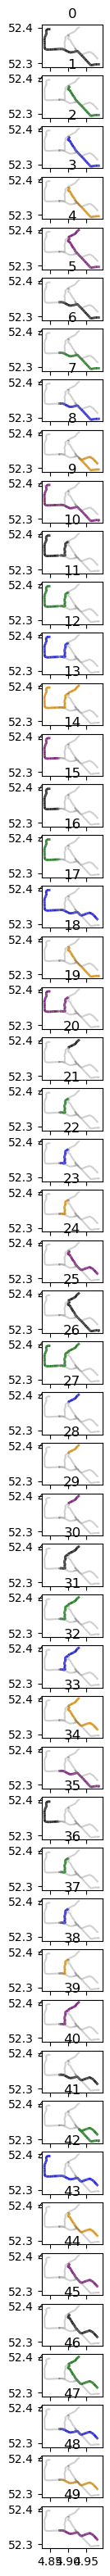

In [62]:
plot_OD_routes(OD_shortest_path_edges,city_sub_connected_edges)

## Test OD pairs under disruptions

In [63]:
def remove_edges_by_percentage(graph, percentage):
    num_edges_to_remove = int(len(graph.edges) * percentage)
    
    edges_to_remove = random.sample(graph.edges, num_edges_to_remove)
    
    graph.remove_edges_from(edges_to_remove)
    return edges_to_remove

In [64]:
remove_edges_by_percentage(G1, 0.01)

[(762, 761.0),
 (122, 849.0),
 (851, 220.0),
 (462, 803.0),
 (832, 833.0),
 (830, 832.0)]

In [65]:
OD_dis_shortest_path_nodes_id = {}
OD_dis_shortest_path_edges = {}
OD_dis_length_s_e = {}
for index, row in OD_id_pairs_df.iterrows():
    try:
        path_s_e, length_s_e, short_path_edges = shortest_path(G1, row.s_id, row.e_id, city_sub_connected_edges, weight = "weights")
        OD_dis_shortest_path_nodes_id[index] = path_s_e
        OD_dis_shortest_path_edges[index] = short_path_edges
        OD_dis_length_s_e[index] = length_s_e
    except nx.NetworkXNoPath:
        print(f"No path between {row.s_id} and {row.e_id}. Skipping...")
        continue

No path between 845 and 323. Skipping...
No path between 845 and 728. Skipping...
No path between 845 and 815. Skipping...
No path between 845 and 816. Skipping...
No path between 845 and 716. Skipping...
No path between 845 and 83. Skipping...
No path between 845 and 180. Skipping...
No path between 845 and 840. Skipping...
No path between 845 and 61. Skipping...
No path between 731 and 323. Skipping...
No path between 630 and 323. Skipping...
No path between 345 and 323. Skipping...
No path between 331 and 323. Skipping...


In [66]:
len(OD_dis_shortest_path_edges)

37

In [67]:
OD_dis_shortest_path_edges

{0:          osm_id                                           geometry railway  \
 6      23189059  LINESTRING (4.8392375 52.3821516, 4.8395503 52...  subway   
 7      23189060  LINESTRING (4.8390885 52.3817947, 4.8392375 52...  subway   
 9      23189084  LINESTRING (4.8366641 52.3759929, 4.8369423 52...  subway   
 10     23189087  LINESTRING (4.8354779 52.372858, 4.8356852 52....  subway   
 11     23207770  LINESTRING (4.8344069 52.3521526, 4.834401 52....  subway   
 ..          ...                                                ...     ...   
 523   516180353  LINESTRING (4.8533014 52.3381482, 4.8535898 52...  subway   
 554   609899762  LINESTRING (4.8846464 52.3393094, 4.8844549 52...  subway   
 555   609899763  LINESTRING (4.8775083 52.3394351, 4.8772474 52...  subway   
 557   609899765  LINESTRING (4.8717257 52.339215, 4.8705194 52....  subway   
 614  1013202301  LINESTRING (4.8345938 52.3457866, 4.8345911 52...  subway   
 
        service   id  from_id  to_id    distanc

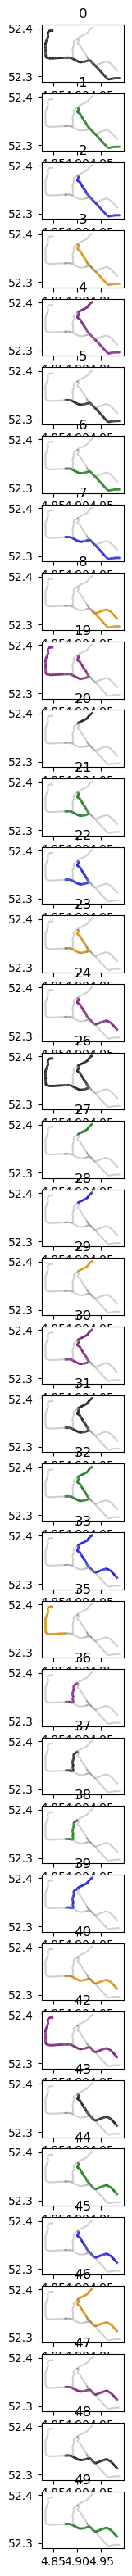

In [68]:
plot_OD_routes(OD_dis_shortest_path_edges,city_sub_connected_edges)

In [ ]:
df = OD_dis_shortest_path_edges[10]
# df

In [ ]:
# gpd.GeoDataFrame(df[['osm_id', 'geometry', 'id', 'from_id', 'to_id', 'distance', 'time', 'weights']]).to_file('OD_dis_shortest_path_edges_df.GPKG',driver='GPKG')

## Create OD id_pairs

In [55]:
origin_df = pd.DataFrame()
each_o_point = pd.DataFrame()

for route_name, station_df in city_sub_order_route_dict.items():
    each_o_point = station_df.loc[[0]]
    origin_df = pd.concat([origin_df,each_o_point])

origin_df.drop_duplicates(subset='geometry', inplace=True)

selected_columns = ['geometry','name']
origin_df = origin_df[selected_columns].reset_index(drop=True)
origin_id_df = pd.merge(origin_df,city_sub_new_nodes,on='geometry',how='left')

In [56]:
origin_id_df

,geometry,name,id,degree
0,POINT (4.9891612 52.2964067),Gein,328,2
1,POINT (4.8505967 52.3952329),Isolatorweg,845,2
2,POINT (4.9008686 52.3773546),Centraal Station,731,2
3,POINT (4.932402 52.4021571),Noord,630,2
4,POINT (4.8780248 52.3393025),Zuid,345,2
5,POINT (4.9842364 52.3115025),Gaasperplas,331,2


In [57]:
destination_df = pd.DataFrame()
each_d_point = pd.DataFrame()

for route_name, station_df in city_sub_order_route_dict.items():
    each_d_point = station_df.loc[[station_df.index[-1]]]
    destination_df = pd.concat([destination_df,each_d_point])

destination_df.drop_duplicates(subset='geometry', inplace=True)

selected_columns = ['geometry','name']
destination_df = destination_df[selected_columns].reset_index(drop=True)
destination_id_df = pd.merge(destination_df,city_sub_new_nodes,on='geometry',how='left')

In [58]:
destination_id_df

,geometry,name,id,degree
0,POINT (4.8505958 52.3951031),Isolatorweg,805,2
1,POINT (4.989299 52.2962711),Gein,323,2
2,POINT (4.9010471 52.3775081),Centraal Station,728,2
3,POINT (4.8772326 52.3393181),Zuid,180,3
4,POINT (4.932585 52.4020575),Noord,716,2
5,POINT (4.9843391 52.3111615),Gaasperplas,61,2


In [59]:
OD_id_list = []

for index_origin, row_origin in origin_id_df.iterrows():

       
    for index_destination, row_destination in destination_id_df.iterrows():


        if row_origin['name'] != row_destination['name']:
            # Append a dictionary to the list
            OD_id_list.append({
                's_id': row_origin['id'],
                'e_id': row_destination['id']
             })

# Create a DataFrame from the list of dictionaries
OD_id_pairs_df = pd.DataFrame(OD_id_list)  
OD_id_pairs_df

,s_id,e_id
0,328,805
1,328,728
2,328,180
3,328,716
4,328,61
5,845,323
6,845,728
7,845,180
8,845,716
9,845,61
